In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np

from irc.manager import IRCManager
from boxforage.utils import plot_single_box_episode, plot_multi_box_episode

# Independent boxes

In [2]:
manager = IRCManager(defaults='defaults/indie_boxes.yaml', read_only=True)

## Overview of sweep training over parameter grid

In [3]:
# with open('param_grids/indie_boxes.yaml') as f:
with open('store/i-grid_0.yaml') as f:
    env_param_grid = yaml.safe_load(f)
for i, label in enumerate(['p_appear', 'p_vanish', 'p_true', 'r_food', 'r_move', 'p_couple']):
    print(f'{label}: {env_param_grid[i]}')            
seeds = range(3)
print(f'seeds: {seeds}')

report = manager.overview(env_param_grid=env_param_grid, seeds=seeds, min_epoch=40)

p_appear: [0.1, 0.2, 0.3]
p_vanish: [0.025, 0.05, 0.075, 0.1]
p_true: [0.6, 0.7, 0.8]
r_food: [10.0]
r_move: [-1.0]
p_couple: [0.0]
seeds: range(0, 3)
Average progress of training 46.9% (40 epochs as complete).
Approximate training time 57m57.49s per epoch.
Approximate evaluation time 6m50.42s.
Average training optimality 94.9%


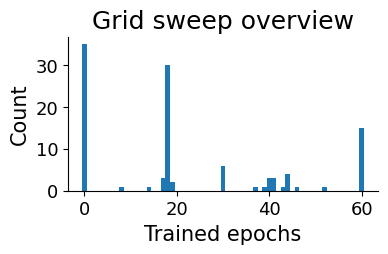

In [4]:
_, ax = plt.subplots(figsize=(4, 2))
ax.hist(report['epoch'], bins=np.arange(min(report['epoch']), max(report['epoch'])+2)-0.5)
ax.set_xlabel('Trained epochs')
ax.set_ylabel('Count')
ax.set_title('Grid sweep overview')
plt.show()

## Inspect a specific agent

Agent (seed 2) was trained for 60 epochs.


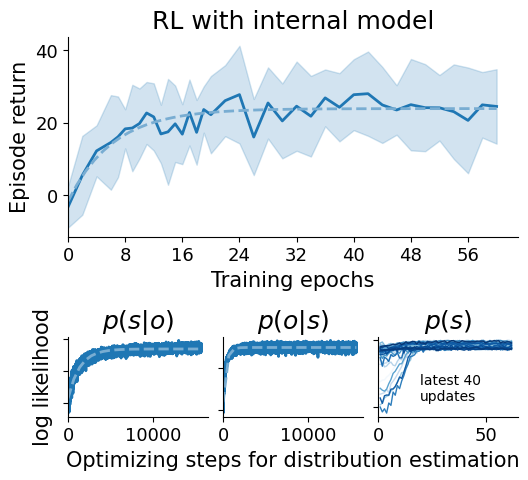

In [5]:
agent, fig = manager.inspect_agent([0.2, 0.05, 0.6, 10.0, -1.0, 0.0], seed=2)

## Agent behavior in a real environment

Color cues in this real environment is more reliable ($p_\mathrm{true}=0.7, p_\mathrm{false}=0.3$) than the agent assumes ($p_\mathrm{true}=0.6, p_\mathrm{false}=0.4$).

In [6]:
from boxforage.multi_box import SimpleBoxForaging

env = SimpleBoxForaging(spec={'boxes': {'p_true': 0.7, 'p_false': 0.3}})
env.spec

{'boxes': {'p_true': array([0.7, 0.7]),
  'p_false': array([0.3, 0.3]),
  'num_boxes': 2,
  'num_shades': 5,
  'p_appear': array([0.2, 0.2]),
  'p_vanish': array([0.05, 0.05])},
 'reward': {'food': 10.0, 'fetch': -1.0, 'move': -1.0},
 'couple': {'p': 0.0, 'num_steps': 1}}

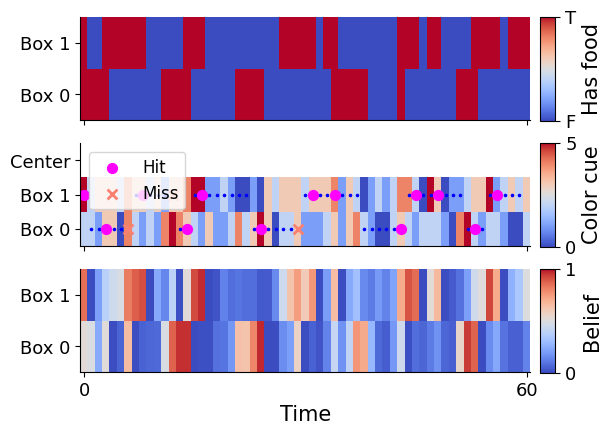

In [7]:
episode = agent.run_one_episode(env=env, num_steps=60)
fig = plot_multi_box_episode(episode)

## Saving and loading behavior data for likelihood computation

### Saving the trial above

In [8]:
actions = episode.pop('actions')
observations = episode.pop('observations')

meta_info = {
    'agent_config': manager.config,
    'real_env': env.spec,
}
meta_info.update(episode)

ep_key = manager.add_episode(actions, observations, meta_info)
print(f"Episode data saved as '{ep_key}'.")

Episode data saved as '152CD4'.


### Loading another trial

Loading episode data in 'FF01DB'...


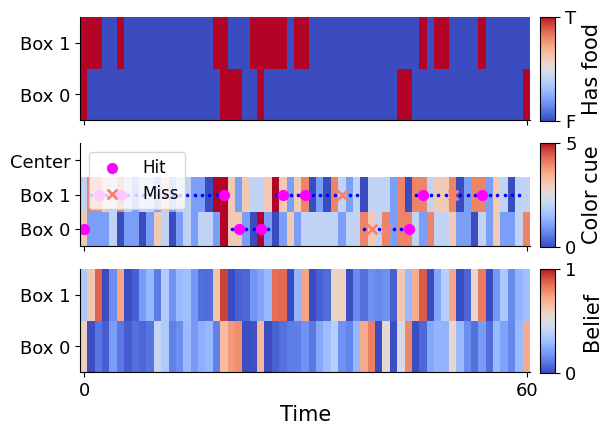

In [9]:
ep_key = 'FF01DB'
print(f"Loading episode data in '{ep_key}'...")

episode = manager.episodes[ep_key]
meta_info = episode.pop('meta_info')

# fetch the agent
config = meta_info.pop('agent_config')
manager.setup(config)
manager.load_ckpt()
agent = manager.agent

# create the environment
spec = meta_info.pop('real_env')
env = SimpleBoxForaging(spec=spec)

episode.update(meta_info)
episode = episode.native()
fig = plot_multi_box_episode(episode)

# Coupled boxes

In [9]:
manager = IRCManager(defaults='defaults/coupled_boxes.yaml', read_only=True)

In [10]:
# with open('param_grids/coupled_boxes.yaml') as f:
with open('store/c-grid_0.yaml') as f:
    env_param_grid = yaml.safe_load(f)
for i, label in enumerate(['p_appear', 'p_vanish', 'p_true', 'r_food', 'r_move', 'p_couple']):
    print(f'{label}: {env_param_grid[i]}')            
seeds = range(3)
print(f'seeds: {seeds}')

report = manager.overview(env_param_grid=env_param_grid, seeds=seeds, min_epoch=40)

p_appear: [0.1, 0.15, 0.2, 0.25, 0.3]
p_vanish: [0.05, 0.1]
p_true: [0.6, 0.7, 0.8]
r_food: [10.0]
r_move: [-1.0]
p_couple: [-0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4]
seeds: range(0, 3)
Average progress of training 30.8% (40 epochs as complete).
Approximate training time 46m34.61s per epoch.
Approximate evaluation time 5m30.77s.
Average training optimality 93.8%


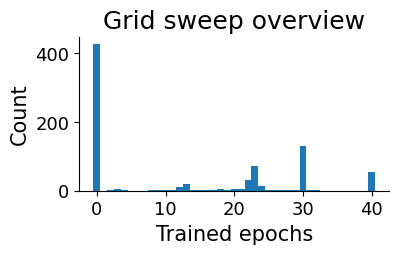

In [11]:
_, ax = plt.subplots(figsize=(4, 2))
ax.hist(report['epoch'], bins=np.arange(min(report['epoch']), max(report['epoch'])+2)-0.5)
ax.set_xlabel('Trained epochs')
ax.set_ylabel('Count')
ax.set_title('Grid sweep overview')
plt.show()